In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import warnings
# import quantstats as qs
# import pyfolio as pf







In [3]:
warnings.simplefilter(action='ignore', category=FutureWarning)

closing_price1 = pd.read_excel('fechamento_limpo.xlsx')
print('1')
quality1 = pd.read_excel('base_quality_limpa.xlsx')
print('1')
low_size1 = pd.read_excel('base_low_size_limpa.xlsx')
print('1')
value1 = pd.read_excel('value_limpo.xlsx')


1
1
1


In [4]:
low_size1["Data"] = pd.to_datetime(low_size1["Data"])
low_size1 = low_size1.set_index("Data")

quality1["Data"] = pd.to_datetime(quality1["Data"])
quality1 = quality1.set_index("Data")

value1["Data"] = pd.to_datetime(value1["Data"])
value1 = value1.set_index("Data")

closing_price1["Data"] = pd.to_datetime(closing_price1["Data"])
closing_price1 = closing_price1.set_index("Data")

In [5]:
dados_ineg1 = pd.read_excel('ineg_limpo (3).xlsx')
dados_ineg1['Data'] = pd.to_datetime(dados_ineg1['Data'])
dados_ineg1 = dados_ineg1.set_index('Data')

In [6]:

initial_date = pd.Timestamp(dt.datetime(2005,1,1))
final_date =pd.Timestamp(dt.datetime(2024,12,31))


low_size2 = low_size1[(low_size1.index >= initial_date) & (low_size1.index <=final_date)]
closing_price2 = closing_price1[(closing_price1.index >= initial_date) & (closing_price1.index <=final_date)]
quality2 = quality1[(quality1.index >= initial_date) & (quality1.index <=final_date)]
value2 = value1[(value1.index >= initial_date) & (value1.index <=final_date)]
dados_ineg2 = dados_ineg1[(dados_ineg1.index >= initial_date) & (dados_ineg1.index <=final_date)]

#-------------------------------------------------------------------------------

# Força o índice para datetime corretamente
closing_price = closing_price1.copy()
closing_price.index = pd.to_datetime(closing_price.index, errors='coerce')
closing_price = closing_price[closing_price.index.notna()]  # remove datas inválidas


low_size = low_size1.copy()
low_size.index = pd.to_datetime(low_size.index, errors='coerce')
low_size = low_size[low_size.index.notna()]


quality = quality1.copy()
quality.index = pd.to_datetime(quality.index, errors='coerce')
quality = quality[quality.index.notna()]


value = value1.copy()
value.index = pd.to_datetime(value.index, errors='coerce')
value = value[value.index.notna()]

#-------------------------------------------------------------------------------
# Colocar os lookcbacks de cada estrategia

lookback_momentum = 6  #  3 mes
lookback_low_size = 9  #  3 mes
lookback_low_vol = 9 #  3 mes
lookback_quality = 6  #  3 mes
lookback_value = 12  #  3 mes
lookback_ibx = 6  #  3 mes

rebal_time = 1  #  1 mes --> unico para toda a carteira

#-------------------------------------------------------------------------------

closing_price = closing_price2.copy()
value = value2.copy()
low_size = low_size2.copy() 
quality = quality2.copy()
dados_ineg = dados_ineg2.copy()

#-------------------------------------------------------------------------------

dados_ineg = dados_ineg.dropna(axis=1, how='all')

cutoff_date = initial_date
dados_ineg = dados_ineg[dados_ineg.index >= cutoff_date]

quality_original = quality.copy()
value_original = value.copy()

# BACKTEST RODANDO

In [7]:
returns = pd.DataFrame()
contador = 0
initial_date = pd.Timestamp(dt.datetime(2005,1,1))


while True:

    rebal = initial_date + pd.DateOffset(months=rebal_time)
    
    if rebal <= final_date:
         
        ineg_date_analysis = initial_date - pd.DateOffset(months=lookback_ibx)
        ineg = dados_ineg[(dados_ineg.index < initial_date) & (dados_ineg.index >= ineg_date_analysis)]
        ineg2 = ineg.copy()
        ineg = ineg.ffill().bfill()

        if not ineg.empty:
                ineg = ineg.iloc[[-1]].T.reset_index()
                ineg.columns = ['ticker', 'neg']
        else:
                initial_date += pd.DateOffset(months=rebal_time)
                continue    # <<<<<< IMPORTANTE AQUI


        #era ticket é o nome da ação e neg é o índice de negociabilidade
        ineg.columns = ['ticker','neg'] if 'neg' not in ineg.columns else ineg.columns


        #no fim essa lista iá significar que as ações investidas estão na lista de boa negociabilidade
        ibx_tickers = ineg.sort_values(by='neg', ascending=False).head(100)['ticker'].tolist()

    # --------------------------------------------------------------

        # OFENSIVA
        
        #momentum:
        # Define o intervalo para analisar o desempenho passado das ações
        momentum_date_analysis = initial_date - pd.DateOffset(months=lookback_momentum)
        # Filtra os preços dentro do intervalo desejado
        momentum = closing_price[(closing_price.index < initial_date) & (closing_price.index > momentum_date_analysis)]

        #cálculo do momentum:
        momentum = momentum.pct_change().add(1).cumprod().add(-1)
        # Pega apenas a última linha dos retornos acumulados (mais recente)
        momentum = momentum.iloc[-1]
        # Converte para DataFrame e renomeia as colunas
        momentum = momentum.reset_index()
        momentum.columns = ['ticker', 'momentum'] #Ticker = nome da ação e value = valor da ação

        momentum = momentum[momentum['ticker'].isin(ibx_tickers)]  #Verifica se a ação está entre as top 100 mais negociadas na bolsa 

        # Ordena da maior performance para a menor
        momentum = momentum.sort_values(by='momentum', ascending=False).reset_index(drop=True)

        # low size em cima de momentum

        momentum_20_pc = momentum.ticker[:int(len(momentum) * 0.2)]
        acoes_20_momentum = momentum_20_pc.tolist()

        low_size_date_analysis = initial_date - pd.DateOffset(months=lookback_low_size)
        low_size_filtro = low_size[(low_size.index < initial_date) & (low_size.index > low_size_date_analysis)]

        if low_size_filtro.empty:
            initial_date += pd.DateOffset(months=rebal_time)
            continue


        low_size_filtro = low_size_filtro.iloc[-1]
        low_size_filtro=low_size_filtro.reset_index()
        low_size_filtro.columns = ['ticker','low_size']

        
        low_size_novo = low_size_filtro[low_size_filtro['ticker'].isin(acoes_20_momentum)]
        low_size_novo = low_size_novo.sort_values(by='low_size', ascending=True).reset_index(drop=True)

        lista_low_size = low_size_novo.ticker.tolist()
        
        book_winners_ofensiva = low_size_novo.ticker[:int(len(low_size_novo) * 0.3)]
        book_winners_ofensiva = book_winners_ofensiva.tolist()

        book_loosers_ofensiva = [coluna for coluna in closing_price.columns if coluna not in book_winners_ofensiva and coluna in ibx_tickers]



# --------------------------------------------------------------
        # DEFENSIVA
        # if (rebal.month - initial_date.month) % 3 == 0 or contador == 0:
        # low vol

        low_vol_date_analysis = initial_date - pd.DateOffset(months=lookback_low_vol)
        low_vol_prices = closing_price[(closing_price.index < initial_date) & (closing_price.index > low_vol_date_analysis)]

        # Calcula volatilidade (desvio padrão dos retornos)
        low_vol = low_vol_prices.pct_change().std()  
        low_vol = low_vol.reset_index()
        low_vol.columns = ['ticker', 'low_vol']

        # Filtra para tickers do IBX
        low_vol = low_vol[low_vol['ticker'].isin(ibx_tickers)]
        low_vol = low_vol.sort_values(by='low_vol', ascending=True).reset_index(drop=True)

        low_vol = low_vol.iloc[:int(len(low_vol) * 0.5)]

        low_vol_score = low_vol.copy()
        low_vol_score['score'] = low_vol.index + 1
        
        lista_low_vol = low_vol.ticker.tolist()


        quality_date_analysis = initial_date - pd.DateOffset(months=lookback_quality)
        quality = quality_original[(quality_original.index < initial_date) & (quality_original.index > quality_date_analysis)]

        if not quality.empty:
                quality = quality.iloc[[-1]].T.reset_index()
                quality.columns = ['ticker','quality']
        else:
                initial_date += pd.DateOffset(months=rebal_time)
                continue

        quality = quality[quality['ticker'].isin(lista_low_vol)]
        quality = quality.sort_values(by='quality', ascending=False).reset_index(drop=True)

        quality_score = quality.copy()
        quality_score['score'] = quality.index + 1

        quality_score['score_result'] = quality_score['score'] + low_vol_score['score']
        quality_score = quality_score.sort_values(by='score_result', ascending=True).reset_index(drop=True)

        acoes_25_quality_low_vol = quality_score.ticker[:int(len(quality_score) * 0.2)] 
        acoes_25_quality_low_vol = acoes_25_quality_low_vol.tolist()


        # value

        value_date_analysis = initial_date - pd.DateOffset(months=lookback_value)
        value = value_original[(value_original.index < initial_date) & (value_original.index > value_date_analysis)]
        value = value.iloc[-1]
        value = value.reset_index()
        value.columns = ['ticker','value']
        value = value[value['ticker'].isin(acoes_25_quality_low_vol)]
        value = value.sort_values(by='value', ascending=False).reset_index(drop=True)


        # book_winners_defensiva = value[value['value'] >= limite_winners]   
        book_winners_defensiva = value.ticker[:int(len(value) * 0.3)]
        book_winners_defensiva = book_winners_defensiva.tolist()

        book_loosers_defensiva = [coluna for coluna in closing_price.columns if coluna not in book_winners_defensiva and coluna in ibx_tickers]


        # Garantir que os loosers não contenham nenhuma ação presente nos winners
        todos_winners = set(book_winners_defensiva) | set(book_winners_ofensiva)
        todos_ibx = set(ibx_tickers)

        # Loosers são os tickers do IBX que não aparecem em nenhum dos books de winners
        book_loosers_geral = list(todos_ibx - todos_winners)

        # Backtest defensiva - winners
        backtest_defensiva_w = closing_price[(closing_price.index >= initial_date) & (closing_price.index < rebal)]
        backtest_defensiva_w = backtest_defensiva_w[book_winners_defensiva].pct_change().replace(np.nan, 0)
        backtest_defensiva_w['Retorno'] = backtest_defensiva_w.mean(axis=1)
        backtest_defensiva_w_ret = backtest_defensiva_w['Retorno'][1:]

        # Backtest ofensiva - winners
        backtest_ofensiva_w = closing_price[(closing_price.index >= initial_date) & (closing_price.index < rebal)]
        backtest_ofensiva_w = backtest_ofensiva_w[book_winners_ofensiva].pct_change().replace(np.nan, 0)
        backtest_ofensiva_w['Retorno'] = backtest_ofensiva_w.mean(axis=1)
        backtest_ofensiva_w_ret = backtest_ofensiva_w['Retorno'][1:]

        # Combina os dois backtests: 80% defensiva + 20% ofensiva
        backtest_winners_ret = 0.7 * backtest_defensiva_w_ret + 0.3 * backtest_ofensiva_w_ret

        # ---------------------------------------------------------------

        # Backtest loosers (reconstruído com exclusão de winners)
        backtest_loosers = closing_price[(closing_price.index >= initial_date) & (closing_price.index < rebal)]
        backtest_loosers = backtest_loosers[book_loosers_geral].pct_change().replace(np.nan, 0)
        backtest_loosers['Retorno'] = backtest_loosers.mean(axis=1)
        backtest_loosers_ret = backtest_loosers['Retorno'][1:]

        # Universo
        backtest_universe = closing_price[(closing_price.index >= initial_date) & (closing_price.index < rebal)]
        backtest_universe = backtest_universe[ibx_tickers].pct_change().replace(np.nan, 0)
        backtest_universe['Retorno'] = backtest_universe.mean(axis=1)
        backtest_universe_ret = backtest_universe['Retorno'][1:]


        # ----------------------------------------------------------------

        # retorno
        retorno_rebal = pd.DataFrame({
            'Winners': backtest_winners_ret,
            'Universo': backtest_universe_ret,
            'Losers': backtest_loosers_ret,
        })


        returns = pd.concat([returns, retorno_rebal], ignore_index=False)

        initial_date = initial_date + pd.DateOffset(months=rebal_time)
        contador +=1
    else:
        break

returns = returns.add(1).cumprod()

returns
# qs.reports.full(returns['Winners'],returns['Universo'])


,Winners,Universo,Losers
Data,,,
2005-02-02,1.018906,1.012470,1.011898
2005-02-03,1.030192,1.029477,1.028838
2005-02-04,1.054699,1.052261,1.052792
2005-02-07,1.054699,1.052261,1.052792
2005-02-08,1.054699,1.052261,1.052792
...,...,...,...
2024-11-25,13.285160,5.192375,4.442069
2024-11-26,13.387917,5.255607,4.496188
2024-11-27,12.919290,5.117394,4.385887


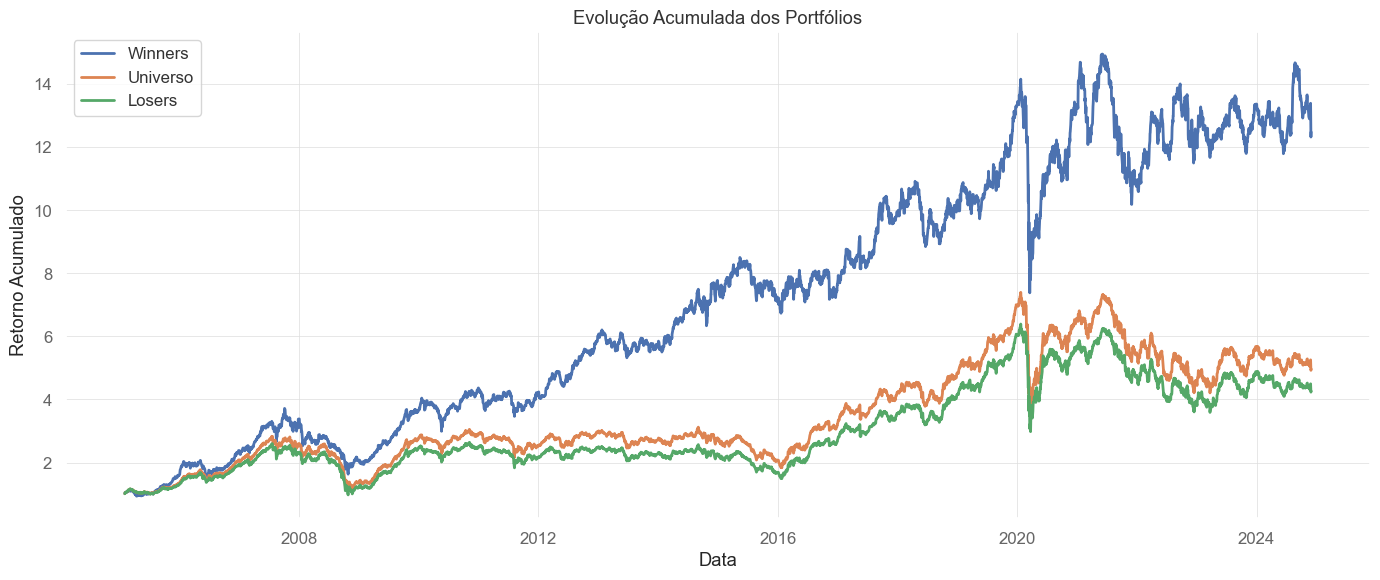

In [9]:
import matplotlib.pyplot as plt

# Gráfico de evolução acumulada dos portfólios
plt.figure(figsize=(14, 6))
plt.plot(returns.index, returns['Winners'], label='Winners', linewidth=2)
plt.plot(returns.index, returns['Universo'], label='Universo', linewidth=2)
plt.plot(returns.index, returns['Losers'], label='Losers', linewidth=2)
plt.title('Evolução Acumulada dos Portfólios')
plt.xlabel('Data')
plt.ylabel('Retorno Acumulado')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


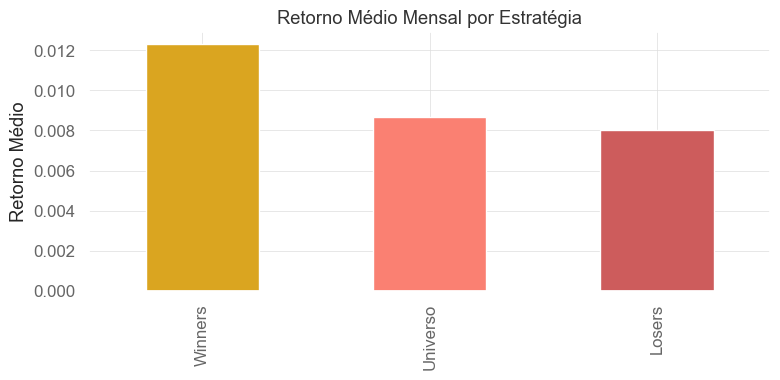

In [12]:
monthly_returns = returns.resample('M').last().pct_change().dropna()
monthly_mean = monthly_returns.mean()


plt.figure(figsize=(8, 4))
monthly_mean.plot(kind='bar', color=['goldenrod', 'salmon', 'indianred'])
plt.title('Retorno Médio Mensal por Estratégia')
plt.ylabel('Retorno Médio')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


<Figure size 1000x500 with 0 Axes>

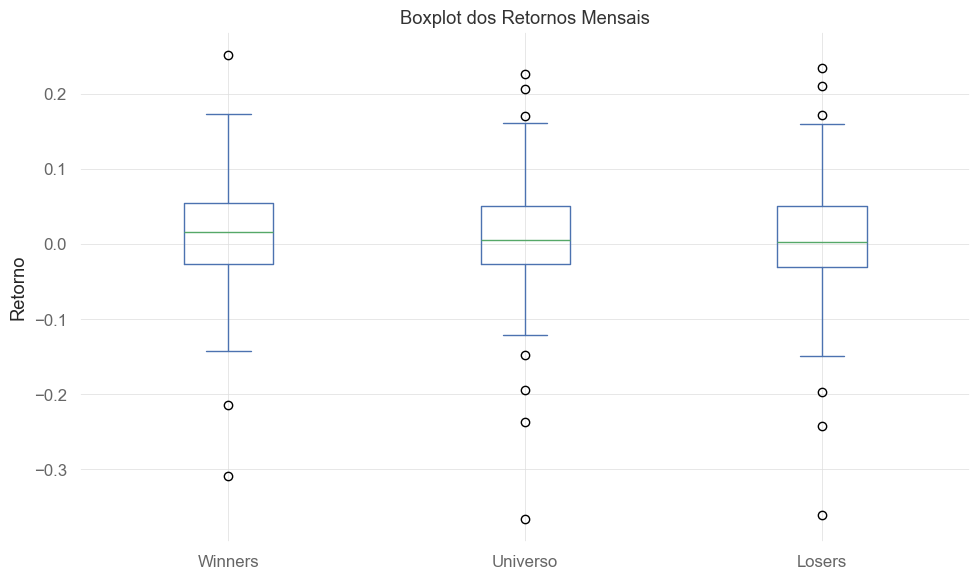

In [13]:

plt.figure(figsize=(10, 5))
monthly_returns.plot(kind='box')
plt.title('Boxplot dos Retornos Mensais')
plt.ylabel('Retorno')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


<Figure size 1400x500 with 0 Axes>

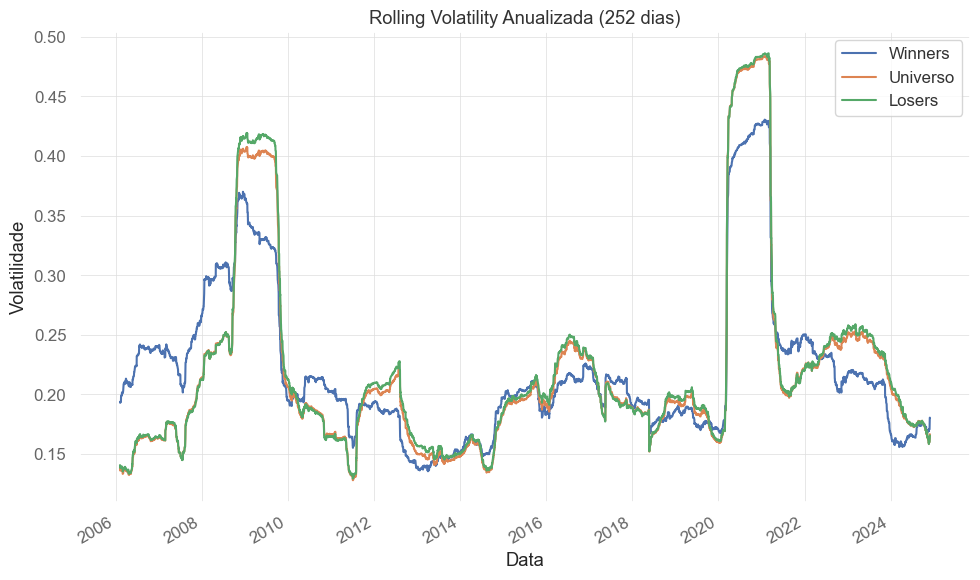

In [18]:

plt.figure(figsize=(14, 5))
daily_returns = returns.pct_change().dropna()
rolling_volatility = daily_returns.rolling(window=252).std() * np.sqrt(252)
rolling_volatility.plot()
plt.title('Rolling Volatility Anualizada (252 dias)')
plt.ylabel('Volatilidade')
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 1400x500 with 0 Axes>

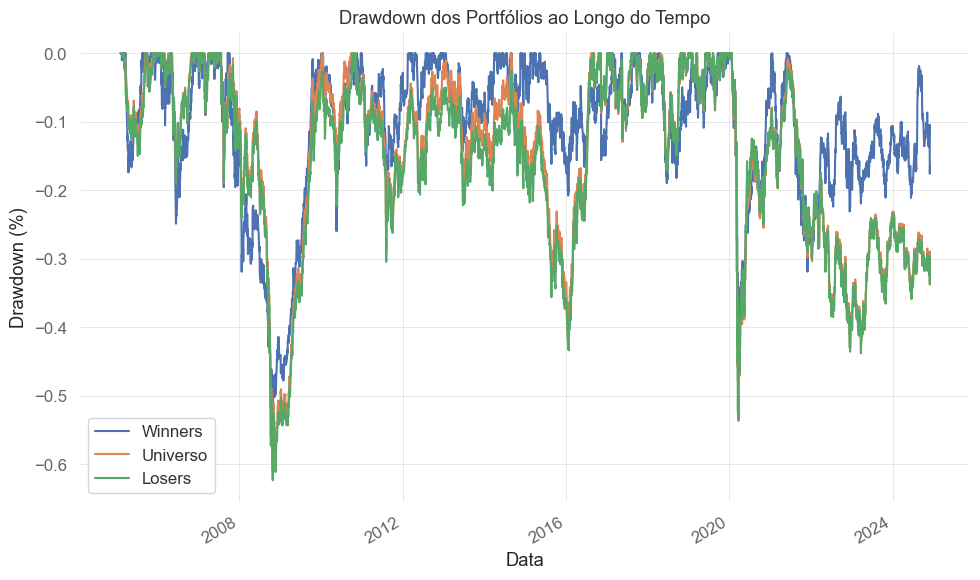

In [21]:
def calculate_drawdown(series):
    cumulative_max = series.cummax()
    drawdown = (series - cumulative_max) / cumulative_max
    return drawdown

drawdowns = returns.apply(calculate_drawdown)

plt.figure(figsize=(14, 5))
drawdowns.plot()
plt.title('Drawdown dos Portfólios ao Longo do Tempo')
plt.ylabel('Drawdown (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 1400x500 with 0 Axes>

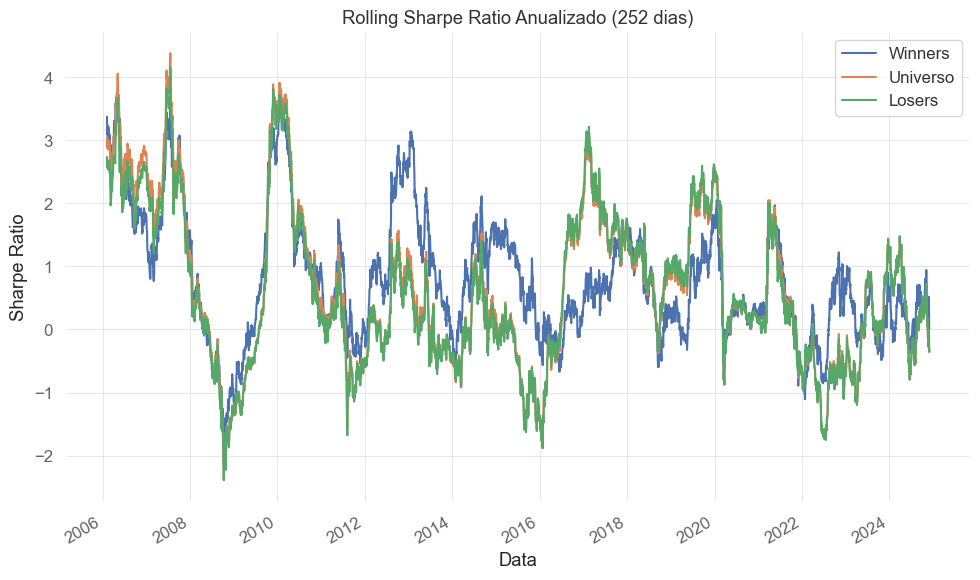

In [23]:


# Retornos diários
daily_returns = returns.pct_change().dropna()

# Rolling Sharpe Ratio (anualizado)
rolling_sharpe = daily_returns.rolling(window=252).mean() / daily_returns.rolling(window=252).std()
rolling_sharpe = rolling_sharpe * np.sqrt(252)

plt.figure(figsize=(14, 5))
rolling_sharpe.plot()
plt.title('Rolling Sharpe Ratio Anualizado (252 dias)')
plt.ylabel('Sharpe Ratio')
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 1000x500 with 0 Axes>

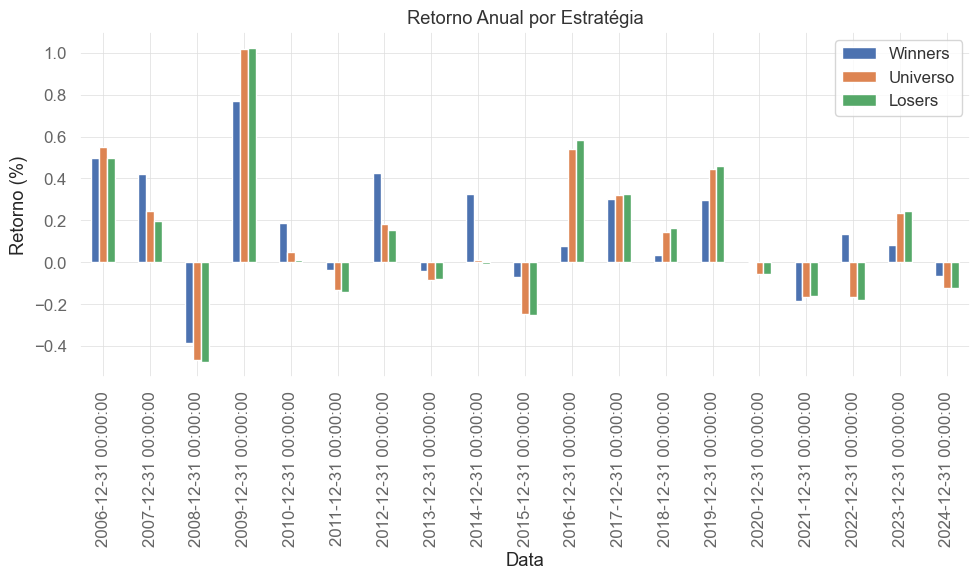

In [25]:
annual_returns = returns.resample('Y').last().pct_change().dropna()
plt.figure(figsize=(10, 5))
annual_returns.plot(kind='bar')
plt.title('Retorno Anual por Estratégia')
plt.ylabel('Retorno (%)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


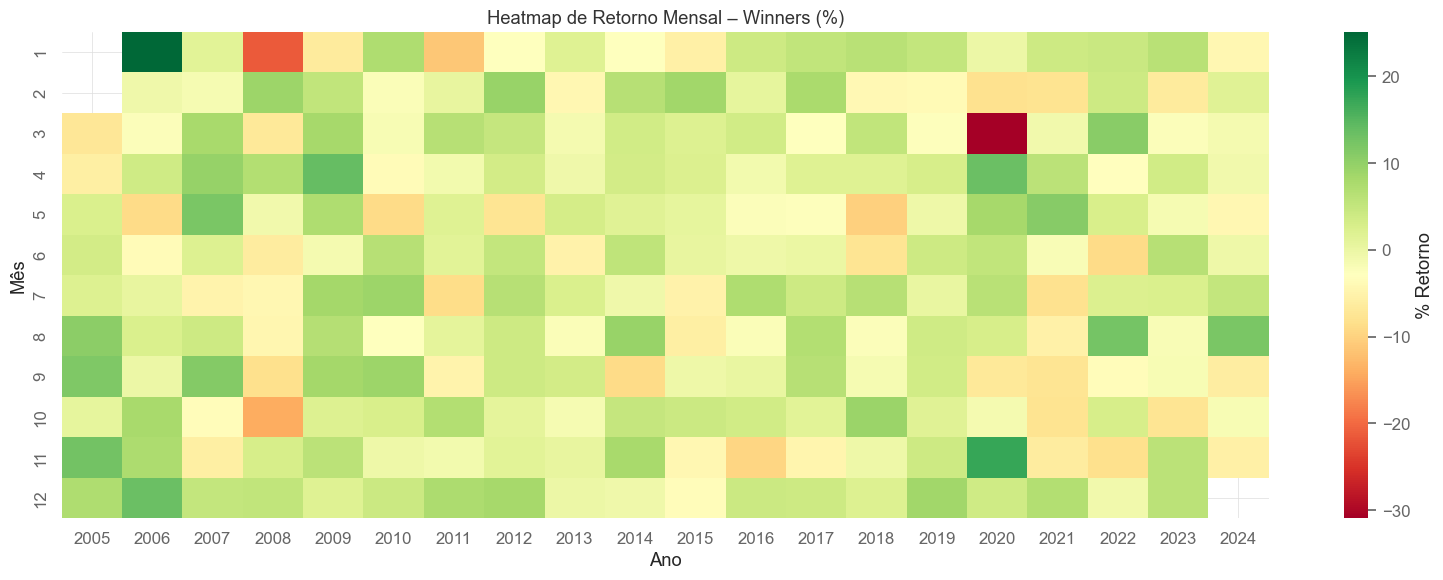

In [27]:
import seaborn as sns
monthly_returns_pct = monthly_returns.copy() * 100
monthly_returns_pct['Year'] = monthly_returns_pct.index.year
monthly_returns_pct['Month'] = monthly_returns_pct.index.month

pivot = monthly_returns_pct.pivot_table(index='Month', columns='Year', values='Winners')

plt.figure(figsize=(16, 6))
sns.heatmap(pivot, annot=False, fmt=".1f", cmap="RdYlGn", cbar_kws={'label': '% Retorno'})
plt.title('Heatmap de Retorno Mensal – Winners (%)')
plt.ylabel('Mês')
plt.xlabel('Ano')
plt.tight_layout()
plt.show()


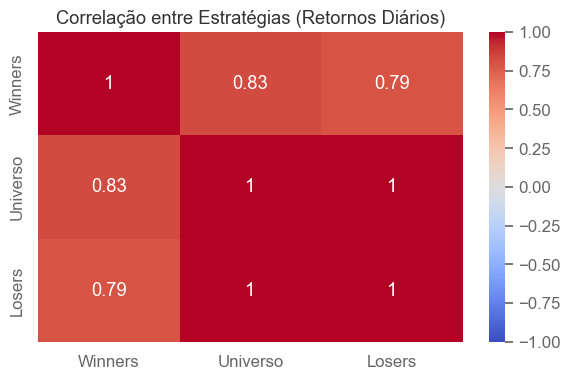

In [28]:

correlation = daily_returns.corr()

plt.figure(figsize=(6, 4))
sns.heatmap(correlation, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title('Correlação entre Estratégias (Retornos Diários)')
plt.tight_layout()
plt.show()


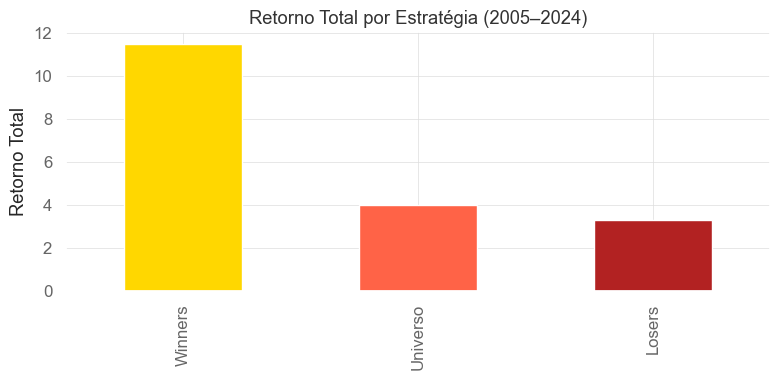

In [30]:

# Calcular retornos diários
daily_returns = returns.pct_change().dropna()

# Calcular drawdown
def calculate_drawdown(series):
    cumulative_max = series.cummax()
    drawdown = (series - cumulative_max) / cumulative_max
    return drawdown

drawdowns = returns.apply(calculate_drawdown)

# Gerar a tabela de estatísticas resumo
def summary_stats(df):
    stats = pd.DataFrame(index=df.columns)
    stats["CAGR"] = (df.iloc[-1] / df.iloc[0])**(1 / (len(df) / 252)) - 1
    stats["Vol (Anual)"] = daily_returns.std() * np.sqrt(252)
    stats["Sharpe"] = stats["CAGR"] / stats["Vol (Anual)"]
    stats["Max Drawdown"] = drawdowns.min()
    stats["Retorno Total"] = df.iloc[-1] - 1
    return stats

summary = summary_stats(returns)
total_return = summary["Retorno Total"]


plt.figure(figsize=(8, 4))
total_return.plot(kind='bar', color=['gold', 'tomato', 'firebrick'])
plt.title('Retorno Total por Estratégia (2005–2024)')
plt.ylabel('Retorno Total')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


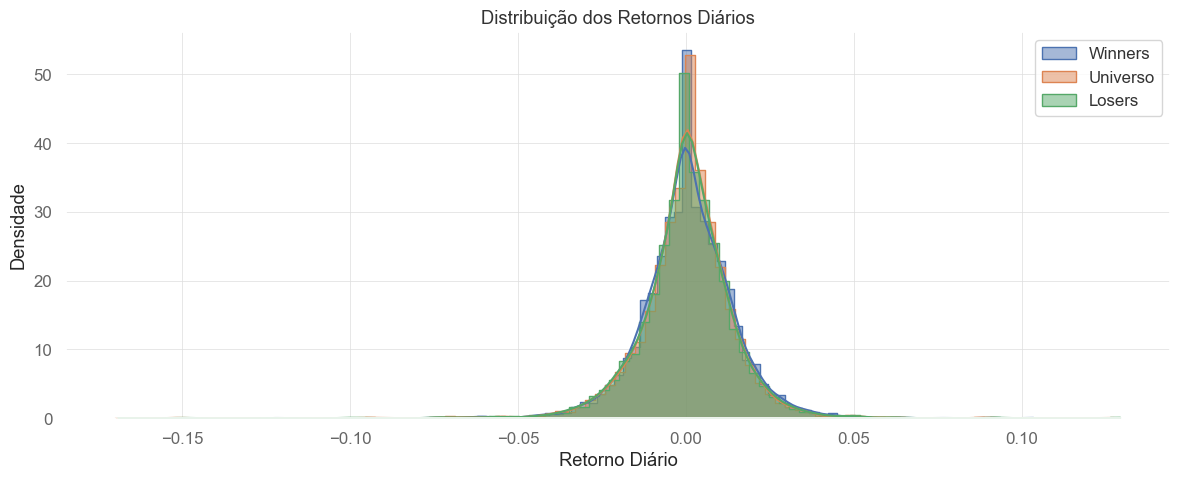

In [31]:

plt.figure(figsize=(12, 5))
for col in daily_returns.columns:
    sns.histplot(daily_returns[col], label=col, kde=True, bins=100, element="step", stat="density")

plt.title("Distribuição dos Retornos Diários")
plt.xlabel("Retorno Diário")
plt.ylabel("Densidade")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


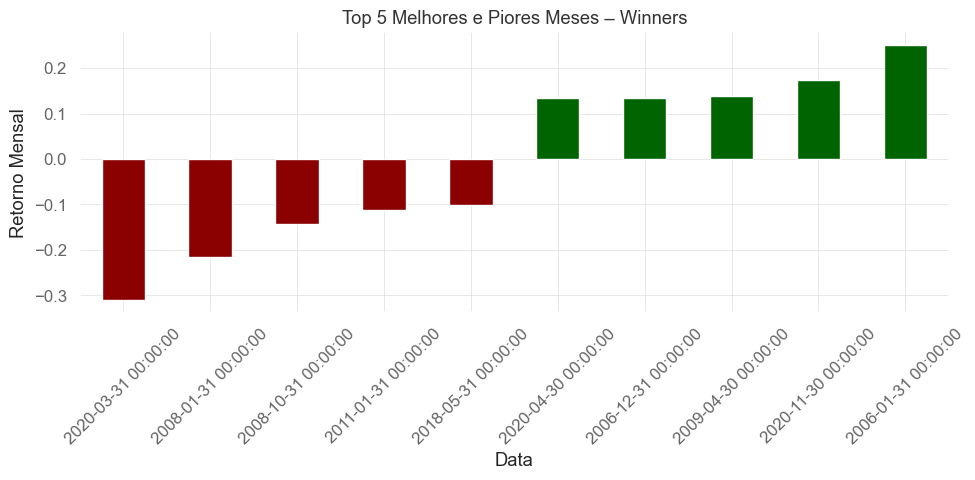

In [32]:

monthly_winners = monthly_returns['Winners']
top5_best = monthly_winners.sort_values(ascending=False).head(5)
top5_worst = monthly_winners.sort_values().head(5)

top5_df = pd.concat([top5_best, top5_worst]).sort_values()

plt.figure(figsize=(10, 5))
top5_df.plot(kind='bar', color=['darkred' if x < 0 else 'darkgreen' for x in top5_df])
plt.title('Top 5 Melhores e Piores Meses – Winners')
plt.ylabel('Retorno Mensal')
plt.grid(True, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [33]:

monthly_table = monthly_returns['Winners'].copy()
monthly_table = monthly_table.to_frame()
monthly_table['Year'] = monthly_table.index.year
monthly_table['Month'] = monthly_table.index.month

pivot_monthly = monthly_table.pivot_table(values='Winners', index='Year', columns='Month')
pivot_monthly.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                         'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
pivot_monthly.round(4)


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2005,NaN,NaN,-0.0708,-0.0576,0.0245,0.0335,0.0207,0.1056,0.1177,0.0080,0.1284,0.0724
2006,0.2513,-0.0066,-0.0224,0.0374,-0.0881,-0.0371,0.0055,0.0244,-0.0025,0.0790,0.0753,0.1350
2007,0.0135,-0.0143,0.0791,0.0972,0.1203,0.0199,-0.0501,0.0405,0.1115,-0.0348,-0.0575,0.0507
2008,-0.2146,0.0907,-0.0694,0.0678,-0.0092,-0.0637,-0.0438,-0.0454,-0.0821,-0.1424,0.0283,0.0531
2009,-0.0658,0.0541,0.0821,0.1377,0.0721,-0.0132,0.0846,0.0661,0.0829,0.0201,0.0594,0.0187
2010,0.0737,-0.0205,-0.0173,-0.0365,-0.0883,0.0645,0.0903,-0.0287,0.0897,0.0259,-0.0037,0.0429
2011,-0.1125,0.0040,0.0642,-0.0103,0.0191,0.0136,-0.0863,0.0088,-0.0496,0.0681,-0.0099,0.0741
2012,-0.0286,0.0955,0.0479,0.0335,-0.0754,0.0504,0.0645,0.0399,0.0410,0.0083,0.0141,0.0824
2013,0.0174,-0.0425,-0.0117,-0.0058,0.0304,-0.0509,0.0241,-0.0221,0.0337,-0.0141,0.0051,-0.0011


In [19]:
print(len(book_winners_ofensiva))
print(len(book_loosers_ofensiva))
print(len(book_winners_defensiva))
print(len(book_loosers_defensiva))
print(len(backtest_winners_ret))
print(len(backtest_loosers_ret))
print(len(backtest_universe_ret))

6
94
6
94
20
20
20


In [ ]:
cont =0
for x in book_loosers_defensiva:
    if x not in book_loosers_ofensiva:
        cont +=1

In [ ]:
print(cont)

60


## OFENSIVA COM LOOP - PRONTA

In [22]:
returns = pd.DataFrame()
contador = 0
initial_date = pd.Timestamp(dt.datetime(2005,1,1))

while True:
    rebal = initial_date + pd.DateOffset(months=rebal_time)

    # print(f"Initial: {initial_date}, Rebal: {rebal}, Final: {final_date}")

    if rebal <= final_date:
         
        ineg_date_analysis = initial_date - pd.DateOffset(months=lookback_ibx)
        ineg = dados_ineg[(dados_ineg.index < initial_date) & (dados_ineg.index >= ineg_date_analysis)]
        ineg2 = ineg.copy()
        ineg = ineg.ffill().bfill()

        if not ineg.empty:
                ineg = ineg.iloc[[-1]].T.reset_index()
                ineg.columns = ['ticker', 'neg']
        else:
                initial_date += pd.DateOffset(months=rebal_time)
                continue    # <<<<<< IMPORTANTE AQUI


        #era ticket é o nome da ação e neg é o índice de negociabilidade
        ineg.columns = ['ticker','neg'] if 'neg' not in ineg.columns else ineg.columns


        #no fim essa lista iá significar que as ações investidas estão na lista de boa negociabilidade
        ibx_tickers = ineg.sort_values(by='neg', ascending=False).head(100)['ticker'].tolist()

    # --------------------------------------------------------------

        # OFENSIVA
        
        #momentum:
        # Define o intervalo para analisar o desempenho passado das ações
        momentum_date_analysis = initial_date - pd.DateOffset(months=lookback_momentum)
        # Filtra os preços dentro do intervalo desejado
        # print(closing_price)
        momentum = closing_price[(closing_price.index < initial_date) & (closing_price.index > momentum_date_analysis)]
        # print(momentum)

        #cálculo do momentum:
        momentum = momentum.pct_change().add(1).cumprod().add(-1)
        # Pega apenas a última linha dos retornos acumulados (mais recente)
        momentum = momentum.iloc[-1]
        # Converte para DataFrame e renomeia as colunas
        momentum = momentum.reset_index()
        momentum.columns = ['ticker', 'momentum'] #Ticker = nome da ação e value = valor da ação
        # print(ibx_tickers)
        momentum = momentum[momentum['ticker'].isin(ibx_tickers)]  #Verifica se a ação está entre as top 100 mais negociadas na bolsa 

        # Ordena da maior performance para a menor
        momentum = momentum.sort_values(by='momentum', ascending=False).reset_index(drop=True)
        # print(momentum)

        # low size em cima de momentum

        # momentum_20_pc = momentum['momentum'].quantile(0.60) 

        # momentum_20_pc = momentum[momentum['momentum'] >= momentum_20_pc]

        momentum_20_pc = momentum.ticker[:int(len(momentum) * 0.3)]
        acoes_20_momentum = momentum_20_pc.tolist()

        low_size_date_analysis = initial_date - pd.DateOffset(months=lookback_low_size)
        low_size_filtro = low_size[(low_size.index < initial_date) & (low_size.index > low_size_date_analysis)]

        if low_size_filtro.empty:
            # print("Sem dados de low_size para:", initial_date)
            initial_date += pd.DateOffset(months=rebal_time)
            continue


        low_size_filtro = low_size_filtro.iloc[-1]
        low_size_filtro=low_size_filtro.reset_index()
        low_size_filtro.columns = ['ticker','low_size']

        
        low_size_novo = low_size_filtro[low_size_filtro['ticker'].isin(acoes_20_momentum)]
        low_size_novo = low_size_novo.sort_values(by='low_size', ascending=True).reset_index(drop=True)

        lista_low_size = low_size_novo.ticker.tolist()
        
        # analisar se faz sentido essa constatação de winners e loosers ou se é ao contrário

        # limite_winners = low_size_novo.low_size.quantile(0.40)

        # book_winners_ofensiva = low_size_novo[low_size_novo['low_size'] <= limite_winners]   
        book_winners_ofensiva = low_size_novo.ticker[:int(len(low_size_novo) * 0.2)]
        book_winners_ofensiva = book_winners_ofensiva.tolist()

        book_loosers_ofensiva = [coluna for coluna in closing_price.columns if coluna not in book_winners_ofensiva and coluna in ibx_tickers]


        # ----------------------------------------------------------------

        # Backtest ofensiva - winners
        backtest_ofensiva_w = closing_price[(closing_price.index >= initial_date) & (closing_price.index < rebal)]
        backtest_ofensiva_w = backtest_ofensiva_w[book_winners_ofensiva].pct_change().replace(np.nan,0)
        backtest_ofensiva_w['Retorno'] = backtest_ofensiva_w.mean(axis=1)
        backtest_ofensiva_w_ret = backtest_ofensiva_w['Retorno'][1:]

        # Backtest ofensiva - loosers
        backtest_ofensiva_l = closing_price[(closing_price.index >= initial_date) & (closing_price.index < rebal)]
        backtest_ofensiva_l = backtest_ofensiva_l[book_loosers_ofensiva].pct_change().replace(np.nan,0)
        backtest_ofensiva_l['Retorno'] = backtest_ofensiva_l.mean(axis=1)
        backtest_ofensiva_l_ret = backtest_ofensiva_l['Retorno'][1:]

        # Universo (opcional: você pode manter o universo como todos os tickers do IBX)
        backtest_universe = closing_price[(closing_price.index >= initial_date) & (closing_price.index < rebal)]
        backtest_universe = backtest_universe[ibx_tickers].pct_change().replace(np.nan,0)
        backtest_universe['Retorno'] = backtest_universe.mean(axis=1)
        backtest_universe_ret = backtest_universe['Retorno'][1:]

        # ----------------------------------------------------------------

        # retorno
        retorno_rebal = pd.DataFrame({
            'Winners': backtest_ofensiva_w_ret,
            'Universo': backtest_universe_ret,
            'Losers': backtest_ofensiva_l_ret,
        })


        returns = pd.concat([returns, retorno_rebal], ignore_index=False)

        initial_date = initial_date + pd.DateOffset(months=rebal_time)
    else:
        break

returns = returns.add(1).cumprod()

returns


,Winners,Universo,Losers
Data,,,
2005-02-02,0.989583,1.012470,1.013931
2005-02-03,1.015044,1.029477,1.030385
2005-02-04,1.020541,1.052261,1.054288
2005-02-07,1.020541,1.052261,1.054288
2005-02-08,1.020541,1.052261,1.054288
...,...,...,...
2024-11-25,12.334485,5.192375,4.740342
2024-11-26,12.537277,5.255607,4.796780
2024-11-27,11.943186,5.117394,4.677089


In [ ]:
print(len(book_winners_ofensiva))
print(len(book_loosers_ofensiva))
print(len(backtest_winners_ret))
print(len(backtest_loosers_ret))
print(len(backtest_universe_ret))

6
94
20
20
20


## DEFENSIVA COM LOOP - TESTE

In [23]:

returns = pd.DataFrame()
contador = 0
initial_date = pd.Timestamp(dt.datetime(2005,1,1))

while True:
        
        rebal = initial_date + pd.DateOffset(months=rebal_time)
        
        if rebal <= final_date:
        
                # DEFENSIVA
                # if (rebal.month - initial_date.month) % 3 == 0 or contador == 0:
                # low vol

                low_vol_date_analysis = initial_date - pd.DateOffset(months=lookback_low_vol)
                # low_vol_prices = closing_price[(closing_price.index < initial_date) & (closing_price.index > low_vol_date_analysis)]

                # # Calcula volatilidade (desvio padrão dos retornos)
                # low_vol = low_vol_prices.pct_change().std()  

                low_vol_prices = closing_price[(closing_price.index < initial_date) & (closing_price.index > low_vol_date_analysis)]

                if low_vol_prices.empty:
                        initial_date += pd.DateOffset(months=rebal_time)
                        continue

                # Calcula volatilidade (desvio padrão dos retornos)
                low_vol = low_vol_prices.pct_change().std()

                low_vol = low_vol.reset_index()
                low_vol.columns = ['ticker', 'low_vol']

                # Filtra para tickers do IBX
                low_vol = low_vol[low_vol['ticker'].isin(ibx_tickers)]
                low_vol = low_vol.sort_values(by='low_vol', ascending=True).reset_index(drop=True)

                # low_vol = low_vol.iloc[:int(len(low_vol) * 0.5)]

                low_vol_score = low_vol.copy()
                low_vol_score['score'] = low_vol.index + 1
                
                lista_low_vol = low_vol.ticker.tolist()


                quality_date_analysis = initial_date - pd.DateOffset(months=lookback_quality)
                quality = quality_original[(quality_original.index < initial_date) & (quality_original.index > quality_date_analysis)]

                if not quality.empty:
                        quality = quality.iloc[[-1]].T.reset_index()
                        quality.columns = ['ticker','quality']
                else:
                        initial_date += pd.DateOffset(months=rebal_time)
                        continue

                quality = quality[quality['ticker'].isin(lista_low_vol)]
                quality = quality.sort_values(by='quality', ascending=False).reset_index(drop=True)

                quality_score = quality.copy()
                quality_score['score'] = quality.index + 1

                quality_score['score_result'] = quality_score['score'] + low_vol_score['score']
                quality_score = quality_score.sort_values(by='score_result', ascending=True).reset_index(drop=True)


                # acoes_25_quality_low_vol_n = quality_score.score_result.quantile(0.50)
                # acoes_25_quality_low_vol = quality_score[quality_score['score_result'] <= acoes_25_quality_low_vol_n]  
                acoes_25_quality_low_vol = quality_score.ticker[:int(len(quality_score) * 0.3)] 
                acoes_25_quality_low_vol = acoes_25_quality_low_vol.tolist()


                # value

                value_date_analysis = initial_date - pd.DateOffset(months=lookback_value)
                value = value_original[(value_original.index < initial_date) & (value_original.index > value_date_analysis)]
                value = value.iloc[-1]
                value = value.reset_index()
                value.columns = ['ticker','value']
                value = value[value['ticker'].isin(acoes_25_quality_low_vol)]
                value = value.sort_values(by='value', ascending=False).reset_index(drop=True)


                # limite_winners = value.value.quantile(0.70)

                # book_winners_defensiva = value[value['value'] >= limite_winners]   
                book_winners_defensiva = value.ticker[:int(len(value) * 0.2)]
                book_winners_defensiva = book_winners_defensiva.tolist()

                book_loosers_defensiva = [coluna for coluna in closing_price.columns if coluna not in book_winners_defensiva and coluna in ibx_tickers]


                # ---------------------------------------------------------------
                # Backtest defensiva - winners
                backtest_defensiva_w = closing_price[(closing_price.index >= initial_date) & (closing_price.index < rebal)]
                backtest_defensiva_w = backtest_defensiva_w[book_winners_defensiva].pct_change().replace(np.nan,0)
                backtest_defensiva_w['Retorno'] = backtest_defensiva_w.mean(axis=1)
                backtest_defensiva_w_ret = backtest_defensiva_w['Retorno'][1:]

                # Backtest defensiva - loosers
                backtest_defensiva_l = closing_price[(closing_price.index >= initial_date) & (closing_price.index < rebal)]
                backtest_defensiva_l = backtest_defensiva_l[book_loosers_defensiva].pct_change().replace(np.nan,0)
                backtest_defensiva_l['Retorno'] = backtest_defensiva_l.mean(axis=1)
                backtest_defensiva_l_ret = backtest_defensiva_l['Retorno'][1:]

                # Universo (opcional: você pode manter o universo como todos os tickers do IBX)
                backtest_universe = closing_price[(closing_price.index >= initial_date) & (closing_price.index < rebal)]
                backtest_universe = backtest_universe[ibx_tickers].pct_change().replace(np.nan,0)
                backtest_universe['Retorno'] = backtest_universe.mean(axis=1)
                backtest_universe_ret = backtest_universe['Retorno'][1:]

                # ----------------------------------------------------------------

                # retorno
                retorno_rebal = pd.DataFrame({
                'Winners': backtest_defensiva_w_ret,
                'Universo': backtest_universe_ret,
                'Losers': backtest_defensiva_l_ret,
                })

                returns = pd.concat([returns, retorno_rebal], ignore_index=False)

                initial_date = initial_date + pd.DateOffset(months=rebal_time)
                contador +=1

        else:
                break

returns = returns.add(1).cumprod()

returns

,Winners,Universo,Losers
Data,,,
2005-02-02,1.023007,1.006954,1.005930
2005-02-03,1.028215,1.012302,1.011286
2005-02-04,1.057617,1.022544,1.020325
2005-02-07,1.057617,1.022544,1.020325
2005-02-08,1.057617,1.022544,1.020325
...,...,...,...
2024-11-25,19.595831,5.798830,5.287228
2024-11-26,19.615827,5.869448,5.355381
2024-11-27,19.180489,5.715091,5.213141


In [ ]:

print(len(book_winners_defensiva))
print(len(book_loosers_defensiva))
print(len(backtest_winners_ret))
print(len(backtest_loosers_ret))
print(len(backtest_universe_ret))

6
94
20
20
20


## Ponderação de Ofensiva e Defensiva

In [ ]:
# ---------------------------------------------------------------

# Backtest defensiva - winners
backtest_defensiva_w = closing_price[(closing_price.index >= initial_date) & (closing_price.index < rebal)]
backtest_defensiva_w = backtest_defensiva_w[book_winners_defensiva].pct_change().replace(np.nan,0)
backtest_defensiva_w['Retorno'] = backtest_defensiva_w.mean(axis=1)
backtest_defensiva_w_ret = backtest_defensiva_w['Retorno'][1:]

# Backtest ofensiva - winners
backtest_ofensiva_w = closing_price[(closing_price.index >= initial_date) & (closing_price.index < rebal)]
backtest_ofensiva_w = backtest_ofensiva_w[book_winners_ofensiva].pct_change().replace(np.nan,0)
backtest_ofensiva_w['Retorno'] = backtest_ofensiva_w.mean(axis=1)
backtest_ofensiva_w_ret = backtest_ofensiva_w['Retorno'][1:]

# Combina os dois backtests: 80% defensiva + 20% ofensiva
backtest_winners_ret = 0.8 * backtest_defensiva_w_ret + 0.2 * backtest_ofensiva_w_ret

#---------------------------------------------------------------

# Backtest defensiva - loosers
backtest_defensiva_l = closing_price[(closing_price.index >= initial_date) & (closing_price.index < rebal)]
backtest_defensiva_l = backtest_defensiva_l[book_loosers_defensiva].pct_change().replace(np.nan,0)
backtest_defensiva_l['Retorno'] = backtest_defensiva_l.mean(axis=1)
backtest_defensiva_l_ret = backtest_defensiva_l['Retorno'][1:]

# Backtest ofensiva - loosers
backtest_ofensiva_l = closing_price[(closing_price.index >= initial_date) & (closing_price.index < rebal)]
backtest_ofensiva_l = backtest_ofensiva_l[book_loosers_ofensiva].pct_change().replace(np.nan,0)
backtest_ofensiva_l['Retorno'] = backtest_ofensiva_l.mean(axis=1)
backtest_ofensiva_l_ret = backtest_ofensiva_l['Retorno'][1:]

# Combina os dois backtests: 80% defensiva + 20% ofensiva
backtest_loosers_ret = 0.8 * backtest_defensiva_l_ret + 0.2 * backtest_ofensiva_l_ret

# Universo (opcional: você pode manter o universo como todos os tickers do IBX)
backtest_universe = closing_price[(closing_price.index >= initial_date) & (closing_price.index < rebal)]
backtest_universe = backtest_universe[ibx_tickers].pct_change().replace(np.nan,0)
backtest_universe['Retorno'] = backtest_universe.mean(axis=1)
backtest_universe_ret = backtest_universe['Retorno'][1:]

# ----------------------------------------------------------------

# retorno
retorno_rebal = pd.DataFrame({
    'Winners': backtest_winners_ret,
    'Universo': backtest_universe_ret,
    'Losers': backtest_loosers_ret,
})


In [ ]:
print('Tamanho losers defensiva:', len(book_loosers_defensiva))
print('Tamanho winners defensiva:', len(book_winners_defensiva))
print('Tamanho losers ofensiva:', len(book_loosers_ofensiva))
print('Tamanho winners defensiva:', len(book_winners_ofensiva))


Tamanho losers defensiva: 80
Tamanho winners defensiva: 9
Tamanho losers ofensiva: 9
Tamanho winners defensiva: 1


## Teste backtest com mesmo rebal

In [ ]:
returns = pd.DataFrame()
contador = 0
initial_date = pd.Timestamp(dt.datetime(2005,1,1))
rebal_time_d = 3

while True:

    rebal = initial_date + pd.DateOffset(months=rebal_time)
    
    # print(f"Initial: {initial_date}, Rebal: {rebal}, Final: {final_date}")

    if rebal <= final_date:
         
        ineg_date_analysis = initial_date - pd.DateOffset(months=lookback_ibx)
        ineg = dados_ineg[(dados_ineg.index < initial_date) & (dados_ineg.index >= ineg_date_analysis)]
        ineg2 = ineg.copy()
        ineg = ineg.ffill().bfill()

        if not ineg.empty:
                ineg = ineg.iloc[[-1]].T.reset_index()
                ineg.columns = ['ticker', 'neg']
        else:
                initial_date += pd.DateOffset(months=rebal_time)
                continue    # <<<<<< IMPORTANTE AQUI


        #era ticket é o nome da ação e neg é o índice de negociabilidade
        ineg.columns = ['ticker','neg'] if 'neg' not in ineg.columns else ineg.columns


        #no fim essa lista iá significar que as ações investidas estão na lista de boa negociabilidade
        ibx_tickers = ineg.sort_values(by='neg', ascending=False).head(100)['ticker'].tolist()

    # --------------------------------------------------------------

        # OFENSIVA
        
        #momentum:
        # Define o intervalo para analisar o desempenho passado das ações
        momentum_date_analysis = initial_date - pd.DateOffset(months=lookback_momentum)
        # Filtra os preços dentro do intervalo desejado
        # print(closing_price)
        momentum = closing_price[(closing_price.index < initial_date) & (closing_price.index > momentum_date_analysis)]
        # print(momentum)

        #cálculo do momentum:
        momentum = momentum.pct_change().add(1).cumprod().add(-1)
        # Pega apenas a última linha dos retornos acumulados (mais recente)
        momentum = momentum.iloc[-1]
        # Converte para DataFrame e renomeia as colunas
        momentum = momentum.reset_index()
        momentum.columns = ['ticker', 'momentum'] #Ticker = nome da ação e value = valor da ação
        # print(ibx_tickers)
        momentum = momentum[momentum['ticker'].isin(ibx_tickers)]  #Verifica se a ação está entre as top 100 mais negociadas na bolsa 

        # Ordena da maior performance para a menor
        momentum = momentum.sort_values(by='momentum', ascending=False).reset_index(drop=True)
        # print(momentum)

        # low size em cima de momentum

        # momentum_20_pc = momentum['momentum'].quantile(0.60) 

        # momentum_20_pc = momentum[momentum['momentum'] >= momentum_20_pc]

        momentum_20_pc = momentum.ticker[:int(len(momentum) * 0.3)]
        acoes_20_momentum = momentum_20_pc.tolist()

        low_size_date_analysis = initial_date - pd.DateOffset(months=lookback_low_size)
        low_size_filtro = low_size[(low_size.index < initial_date) & (low_size.index > low_size_date_analysis)]

        if low_size_filtro.empty:
            # print("Sem dados de low_size para:", initial_date)
            initial_date += pd.DateOffset(months=rebal_time)
            continue


        low_size_filtro = low_size_filtro.iloc[-1]
        low_size_filtro=low_size_filtro.reset_index()
        low_size_filtro.columns = ['ticker','low_size']

        
        low_size_novo = low_size_filtro[low_size_filtro['ticker'].isin(acoes_20_momentum)]
        low_size_novo = low_size_novo.sort_values(by='low_size', ascending=True).reset_index(drop=True)

        lista_low_size = low_size_novo.ticker.tolist()
        
        # analisar se faz sentido essa constatação de winners e loosers ou se é ao contrário

        # limite_winners = low_size_novo.low_size.quantile(0.40)

        # book_winners_ofensiva = low_size_novo[low_size_novo['low_size'] <= limite_winners]   
        book_winners_ofensiva = low_size_novo.ticker[:int(len(low_size_novo) * 0.2)]
        book_winners_ofensiva = book_winners_ofensiva.tolist()

        book_loosers_ofensiva = [coluna for coluna in closing_price.columns if coluna not in book_winners_ofensiva and coluna in ibx_tickers]



# --------------------------------------------------------------
        # DEFENSIVA
        # low vol

        low_vol_date_analysis = initial_date - pd.DateOffset(months=lookback_low_vol)
        low_vol_prices = closing_price[(closing_price.index < initial_date) & (closing_price.index > low_vol_date_analysis)]

        # Calcula volatilidade (desvio padrão dos retornos)
        low_vol = low_vol_prices.pct_change().std()  
        low_vol = low_vol.reset_index()
        low_vol.columns = ['ticker', 'low_vol']

        # Filtra para tickers do IBX
        low_vol = low_vol[low_vol['ticker'].isin(ibx_tickers)]
        low_vol = low_vol.sort_values(by='low_vol', ascending=True).reset_index(drop=True)

        low_vol_score = low_vol.copy()
        low_vol_score['score'] = low_vol.index + 1
        
        lista_low_vol = low_vol.ticker.tolist()


        quality_date_analysis = initial_date - pd.DateOffset(months=lookback_quality)
        quality = quality_original[(quality_original.index < initial_date) & (quality_original.index > quality_date_analysis)]

        if not quality.empty:
                quality = quality.iloc[[-1]].T.reset_index()
                quality.columns = ['ticker','quality']
        else:
                initial_date += pd.DateOffset(months=rebal_time)
                continue

        quality = quality[quality['ticker'].isin(lista_low_vol)]
        quality = quality.sort_values(by='quality', ascending=False).reset_index(drop=True)

        quality_score = quality.copy()
        quality_score['score'] = quality.index + 1

        quality_score['score_result'] = quality_score['score'] + low_vol_score['score']
        quality_score = quality_score.sort_values(by='score_result', ascending=True).reset_index(drop=True)


        # acoes_25_quality_low_vol_n = quality_score.score_result.quantile(0.50)
        # acoes_25_quality_low_vol = quality_score[quality_score['score_result'] <= acoes_25_quality_low_vol_n]  
        acoes_25_quality_low_vol = quality_score.ticker[:int(len(quality_score) * 0.3)] 
        acoes_25_quality_low_vol = acoes_25_quality_low_vol.tolist()


        # value

        value_date_analysis = initial_date - pd.DateOffset(months=lookback_value)
        value = value_original[(value_original.index < initial_date) & (value_original.index > value_date_analysis)]
        value = value.iloc[-1]
        value = value.reset_index()
        value.columns = ['ticker','value']
        value = value[value['ticker'].isin(acoes_25_quality_low_vol)]
        value = value.sort_values(by='value', ascending=False).reset_index(drop=True)


        # limite_winners = value.value.quantile(0.70)

        # book_winners_defensiva = value[value['value'] >= limite_winners]   
        book_winners_defensiva = value.ticker[:int(len(value) * 0.2)]
        book_winners_defensiva = book_winners_defensiva.tolist()

        book_loosers_defensiva = [coluna for coluna in closing_price.columns if coluna not in book_winners_defensiva and coluna in ibx_tickers]


        # ---------------------------------------------------------------
        # Backtest defensiva - winners
        backtest_defensiva_w = closing_price[(closing_price.index >= initial_date) & (closing_price.index < rebal)]
        backtest_defensiva_w = backtest_defensiva_w[book_winners_defensiva].pct_change().replace(np.nan,0)
        backtest_defensiva_w['Retorno'] = backtest_defensiva_w.mean(axis=1)
        backtest_defensiva_w_ret = backtest_defensiva_w['Retorno'][1:]

        # Backtest ofensiva - winners
        backtest_ofensiva_w = closing_price[(closing_price.index >= initial_date) & (closing_price.index < rebal)]
        backtest_ofensiva_w = backtest_ofensiva_w[book_winners_ofensiva].pct_change().replace(np.nan,0)
        backtest_ofensiva_w['Retorno'] = backtest_ofensiva_w.mean(axis=1)
        backtest_ofensiva_w_ret = backtest_ofensiva_w['Retorno'][1:]

        # Combina os dois backtests: 80% defensiva + 20% ofensiva
        backtest_winners_ret = 0.8 * backtest_defensiva_w_ret + 0.2 * backtest_ofensiva_w_ret

        #---------------------------------------------------------------

        # Backtest defensiva - loosers
        backtest_defensiva_l = closing_price[(closing_price.index >= initial_date) & (closing_price.index < rebal)]
        backtest_defensiva_l = backtest_defensiva_l[book_loosers_defensiva].pct_change().replace(np.nan,0)
        backtest_defensiva_l['Retorno'] = backtest_defensiva_l.mean(axis=1)
        backtest_defensiva_l_ret = backtest_defensiva_l['Retorno'][1:]

        # Backtest ofensiva - loosers
        backtest_ofensiva_l = closing_price[(closing_price.index >= initial_date) & (closing_price.index < rebal)]
        backtest_ofensiva_l = backtest_ofensiva_l[book_loosers_ofensiva].pct_change().replace(np.nan,0)
        backtest_ofensiva_l['Retorno'] = backtest_ofensiva_l.mean(axis=1)
        backtest_ofensiva_l_ret = backtest_ofensiva_l['Retorno'][1:]

        # Combina os dois backtests: 80% defensiva + 20% ofensiva
        backtest_loosers_ret = 0.8 * backtest_defensiva_l_ret + 0.2 * backtest_ofensiva_l_ret

        # Universo (opcional: você pode manter o universo como todos os tickers do IBX)
        backtest_universe = closing_price[(closing_price.index >= initial_date) & (closing_price.index < rebal)]
        backtest_universe = backtest_universe[ibx_tickers].pct_change().replace(np.nan,0)
        backtest_universe['Retorno'] = backtest_universe.mean(axis=1)
        backtest_universe_ret = backtest_universe['Retorno'][1:]

        # ----------------------------------------------------------------

        # retorno
        retorno_rebal = pd.DataFrame({
            'Winners': backtest_winners_ret,
            'Universo': backtest_universe_ret,
            'Losers': backtest_loosers_ret,
        })


        returns = pd.concat([returns, retorno_rebal], ignore_index=False)

        initial_date = initial_date + pd.DateOffset(months=rebal_time)
        contador +=1
    else:
        break

returns = returns.add(1).cumprod()

returns
# qs.reports.full(returns['Winners'],returns['Universo'])


,Winners,Universo,Losers
Data,,,
2005-02-02,1.011130,1.012470,1.012555
2005-02-03,1.026540,1.029477,1.029665
2005-02-04,1.052402,1.052261,1.052251
2005-02-07,1.052402,1.052261,1.052251
2005-02-08,1.052402,1.052261,1.052251
...,...,...,...
2024-11-25,8.601935,5.192375,4.977381
2024-11-26,8.631259,5.255607,5.040782
2024-11-27,8.406972,5.117394,4.908117


## BACTEST RODANDO INICIALMENTE, COM DEFENSIVA EM 3 MESES

In [ ]:
returns = pd.DataFrame()
contador = 0
initial_date = pd.Timestamp(dt.datetime(2005,1,1))


while True:

    rebal = initial_date + pd.DateOffset(months=rebal_time)
    
    # print(f"Initial: {initial_date}, Rebal: {rebal}, Final: {final_date}")

    if rebal <= final_date:
         
        ineg_date_analysis = initial_date - pd.DateOffset(months=lookback_ibx)
        ineg = dados_ineg[(dados_ineg.index < initial_date) & (dados_ineg.index >= ineg_date_analysis)]
        ineg2 = ineg.copy()
        ineg = ineg.ffill().bfill()

        if not ineg.empty:
                ineg = ineg.iloc[[-1]].T.reset_index()
                ineg.columns = ['ticker', 'neg']
        else:
                initial_date += pd.DateOffset(months=rebal_time)
                continue    # <<<<<< IMPORTANTE AQUI


        #era ticket é o nome da ação e neg é o índice de negociabilidade
        ineg.columns = ['ticker','neg'] if 'neg' not in ineg.columns else ineg.columns


        #no fim essa lista iá significar que as ações investidas estão na lista de boa negociabilidade
        ibx_tickers = ineg.sort_values(by='neg', ascending=False).head(100)['ticker'].tolist()

    # --------------------------------------------------------------

        # OFENSIVA
        
        #momentum:
        # Define o intervalo para analisar o desempenho passado das ações
        momentum_date_analysis = initial_date - pd.DateOffset(months=lookback_momentum)
        # Filtra os preços dentro do intervalo desejado
        # print(closing_price)
        momentum = closing_price[(closing_price.index < initial_date) & (closing_price.index > momentum_date_analysis)]
        # print(momentum)

        #cálculo do momentum:
        momentum = momentum.pct_change().add(1).cumprod().add(-1)
        # Pega apenas a última linha dos retornos acumulados (mais recente)
        momentum = momentum.iloc[-1]
        # Converte para DataFrame e renomeia as colunas
        momentum = momentum.reset_index()
        momentum.columns = ['ticker', 'momentum'] #Ticker = nome da ação e value = valor da ação
        # print(ibx_tickers)
        momentum = momentum[momentum['ticker'].isin(ibx_tickers)]  #Verifica se a ação está entre as top 100 mais negociadas na bolsa 

        # Ordena da maior performance para a menor
        momentum = momentum.sort_values(by='momentum', ascending=False).reset_index(drop=True)
        # print(momentum)

        # low size em cima de momentum

        # momentum_20_pc = momentum['momentum'].quantile(0.60) 

        # momentum_20_pc = momentum[momentum['momentum'] >= momentum_20_pc]

        momentum_20_pc = momentum.ticker[:int(len(momentum) * 0.3)]
        acoes_20_momentum = momentum_20_pc.tolist()

        low_size_date_analysis = initial_date - pd.DateOffset(months=lookback_low_size)
        low_size_filtro = low_size[(low_size.index < initial_date) & (low_size.index > low_size_date_analysis)]

        if low_size_filtro.empty:
            # print("Sem dados de low_size para:", initial_date)
            initial_date += pd.DateOffset(months=rebal_time)
            continue


        low_size_filtro = low_size_filtro.iloc[-1]
        low_size_filtro=low_size_filtro.reset_index()
        low_size_filtro.columns = ['ticker','low_size']

        
        low_size_novo = low_size_filtro[low_size_filtro['ticker'].isin(acoes_20_momentum)]
        low_size_novo = low_size_novo.sort_values(by='low_size', ascending=True).reset_index(drop=True)

        lista_low_size = low_size_novo.ticker.tolist()
        
        # analisar se faz sentido essa constatação de winners e loosers ou se é ao contrário

        # limite_winners = low_size_novo.low_size.quantile(0.40)

        # book_winners_ofensiva = low_size_novo[low_size_novo['low_size'] <= limite_winners]   
        book_winners_ofensiva = low_size_novo.ticker[:int(len(low_size_novo) * 0.2)]
        book_winners_ofensiva = book_winners_ofensiva.tolist()

        book_loosers_ofensiva = [coluna for coluna in closing_price.columns if coluna not in book_winners_ofensiva and coluna in ibx_tickers]



# --------------------------------------------------------------
        # DEFENSIVA
        if (rebal.month - initial_date.month) % 3 == 0 or contador == 0:
            # low vol

            low_vol_date_analysis = initial_date - pd.DateOffset(months=lookback_low_vol)
            low_vol_prices = closing_price[(closing_price.index < initial_date) & (closing_price.index > low_vol_date_analysis)]

            # Calcula volatilidade (desvio padrão dos retornos)
            low_vol = low_vol_prices.pct_change().std()  
            low_vol = low_vol.reset_index()
            low_vol.columns = ['ticker', 'low_vol']

            # Filtra para tickers do IBX
            low_vol = low_vol[low_vol['ticker'].isin(ibx_tickers)]
            low_vol = low_vol.sort_values(by='low_vol', ascending=True).reset_index(drop=True)

            low_vol_score = low_vol.copy()
            low_vol_score['score'] = low_vol.index + 1
            
            lista_low_vol = low_vol.ticker.tolist()


            quality_date_analysis = initial_date - pd.DateOffset(months=lookback_quality)
            quality = quality_original[(quality_original.index < initial_date) & (quality_original.index > quality_date_analysis)]

            if not quality.empty:
                    quality = quality.iloc[[-1]].T.reset_index()
                    quality.columns = ['ticker','quality']
            else:
                    initial_date += pd.DateOffset(months=rebal_time)
                    continue

            quality = quality[quality['ticker'].isin(lista_low_vol)]
            quality = quality.sort_values(by='quality', ascending=False).reset_index(drop=True)

            quality_score = quality.copy()
            quality_score['score'] = quality.index + 1

            quality_score['score_result'] = quality_score['score'] + low_vol_score['score']
            quality_score = quality_score.sort_values(by='score_result', ascending=True).reset_index(drop=True)


            # acoes_25_quality_low_vol_n = quality_score.score_result.quantile(0.50)
            # acoes_25_quality_low_vol = quality_score[quality_score['score_result'] <= acoes_25_quality_low_vol_n]  
            acoes_25_quality_low_vol = quality_score.ticker[:int(len(quality_score) * 0.3)] 
            acoes_25_quality_low_vol = acoes_25_quality_low_vol.tolist()


            # value

            value_date_analysis = initial_date - pd.DateOffset(months=lookback_value)
            value = value_original[(value_original.index < initial_date) & (value_original.index > value_date_analysis)]
            value = value.iloc[-1]
            value = value.reset_index()
            value.columns = ['ticker','value']
            value = value[value['ticker'].isin(acoes_25_quality_low_vol)]
            value = value.sort_values(by='value', ascending=False).reset_index(drop=True)


            # limite_winners = value.value.quantile(0.70)

            # book_winners_defensiva = value[value['value'] >= limite_winners]   
            book_winners_defensiva = value.ticker[:int(len(value) * 0.2)]
            book_winners_defensiva = book_winners_defensiva.tolist()

            book_loosers_defensiva = [coluna for coluna in closing_price.columns if coluna not in book_winners_defensiva and coluna in ibx_tickers]


        # ---------------------------------------

        # # Backtest defensiva - loosers
        # backtest_defensiva_l = closing_price[(closing_price.index >= initial_date) & (closing_price.index < rebal)]
        # backtest_defensiva_l = backtest_defensiva_l[book_loosers_defensiva].pct_change().replace(np.nan,0)
        # backtest_defensiva_l['Retorno'] = backtest_defensiva_l.mean(axis=1)
        # backtest_defensiva_l_ret = backtest_defensiva_l['Retorno'][1:]

        # # Backtest ofensiva - loosers
        # backtest_ofensiva_l = closing_price[(closing_price.index >= initial_date) & (closing_price.index < rebal)]
        # backtest_ofensiva_l = backtest_ofensiva_l[book_loosers_ofensiva].pct_change().replace(np.nan,0)
        # backtest_ofensiva_l['Retorno'] = backtest_ofensiva_l.mean(axis=1)
        # backtest_ofensiva_l_ret = backtest_ofensiva_l['Retorno'][1:]

        # # Combina os dois backtests: 80% defensiva + 20% ofensiva
        # backtest_loosers_ret = 0.8 * backtest_defensiva_l_ret + 0.2 * backtest_ofensiva_l_ret

        # ---------------------------------------

        # Garantir que os loosers não contenham nenhuma ação presente nos winners
        todos_winners = set(book_winners_defensiva) | set(book_winners_ofensiva)
        todos_ibx = set(ibx_tickers)

        # Loosers são os tickers do IBX que não aparecem em nenhum dos books de winners
        book_loosers_geral = list(todos_ibx - todos_winners)

        # Backtest defensiva - winners
        backtest_defensiva_w = closing_price[(closing_price.index >= initial_date) & (closing_price.index < rebal)]
        backtest_defensiva_w = backtest_defensiva_w[book_winners_defensiva].pct_change().replace(np.nan, 0)
        backtest_defensiva_w['Retorno'] = backtest_defensiva_w.mean(axis=1)
        backtest_defensiva_w_ret = backtest_defensiva_w['Retorno'][1:]

        # Backtest ofensiva - winners
        backtest_ofensiva_w = closing_price[(closing_price.index >= initial_date) & (closing_price.index < rebal)]
        backtest_ofensiva_w = backtest_ofensiva_w[book_winners_ofensiva].pct_change().replace(np.nan, 0)
        backtest_ofensiva_w['Retorno'] = backtest_ofensiva_w.mean(axis=1)
        backtest_ofensiva_w_ret = backtest_ofensiva_w['Retorno'][1:]

        # Combina os dois backtests: 80% defensiva + 20% ofensiva
        backtest_winners_ret = 0.8 * backtest_defensiva_w_ret + 0.2 * backtest_ofensiva_w_ret

        # ---------------------------------------------------------------

        # Backtest loosers (reconstruído com exclusão de winners)
        backtest_loosers = closing_price[(closing_price.index >= initial_date) & (closing_price.index < rebal)]
        backtest_loosers = backtest_loosers[book_loosers_geral].pct_change().replace(np.nan, 0)
        backtest_loosers['Retorno'] = backtest_loosers.mean(axis=1)
        backtest_loosers_ret = backtest_loosers['Retorno'][1:]

        # Universo
        backtest_universe = closing_price[(closing_price.index >= initial_date) & (closing_price.index < rebal)]
        backtest_universe = backtest_universe[ibx_tickers].pct_change().replace(np.nan, 0)
        backtest_universe['Retorno'] = backtest_universe.mean(axis=1)
        backtest_universe_ret = backtest_universe['Retorno'][1:]


        # ----------------------------------------------------------------

        # retorno
        retorno_rebal = pd.DataFrame({
            'Winners': backtest_winners_ret,
            'Universo': backtest_universe_ret,
            'Losers': backtest_loosers_ret,
        })


        returns = pd.concat([returns, retorno_rebal], ignore_index=False)

        initial_date = initial_date + pd.DateOffset(months=rebal_time)
        contador +=1
    else:
        break

returns = returns.add(1).cumprod()

returns
# qs.reports.full(returns['Winners'],returns['Universo'])


,Winners,Universo,Losers
Data,,,
2005-02-02,1.011130,1.012470,1.013754
2005-02-03,1.026540,1.029477,1.030455
2005-02-04,1.052402,1.052261,1.053872
2005-02-07,1.052402,1.052261,1.053872
2005-02-08,1.052402,1.052261,1.053872
...,...,...,...
2024-11-25,8.435566,5.192375,4.820565
2024-11-26,8.467237,5.255607,4.881365
2024-11-27,8.281824,5.117394,4.757893
